<div class="alert alert-danger" style="color:black"><b>Running ML-LV Jupyter Notebooks:</b><br>
    <ol>
        <li>Make sure you are running all notebooks using the <code>adv_ai</code> kernel.
        <li><b>It is very important that you do not create any additional files within the weekly folders on CSCT cloud.</b> Any additional files, or editing the notebooks with a different environment may prevent submission/marking of your work.</li>
            <ul>
                <li>NBGrader will automatically fetch and create the correct folders files for you.</li>
                <li>All files that are not the Jupyter notebooks should be stored in the 'ML-LV/data' directory.</li>
            </ul>
        <li>Please <b>do not pip install</b> any python packages (or anything else). You should not need to install anything to complete these notebooks other than the packages provided in the Jupyter CSCT Cloud environment.</li>
    </ol>
    <b>If you would like to run this notebook locally you should:</b><br>
    <ol>
        <li>Create an environment using the requirements.txt file provided. <b>Any additional packages you install will not be accessible when uploaded to the server and may prevent marking.</b></li>
        <li>Download a copy  of the notebook to your own machine. You can then edit the cells as you wish and then go back and copy the code into/edit the ones on the CSCT cloud in-place.</li>
        <li><b>It is very important that you do not re-upload any notebooks that you have edited locally.</b> This is because NBGrader uses cell metadata to track marked tasks. <b>If you change this format it may prevent marking.</b></li>
    </ol>
</div>

# Practical 10: Object Recognition

In the previous practical we applied CNN's to the MNIST and Flowers datasets. Image classification is a precursor to many other MV tasks, such as: object *localisation* which finds one or more objects within an image and identifies their location with a bounding box, and object *detection* which finds one or more objects within an image and identifies their location with a bounding box and also their class.

Object recognition typically requires much more sophisticated architecture and inputs. For example, bounding boxes require more time to label, particularly if the image contains many objects of different classes. Similarly, multi-object recognition also requires much more sophisticated architecture which is capable of detecting multiple-classes and their bounding boxes simultaneously. These models typically have multiple outputs, or classification heads, for handling class and bounding box predictions.

In the first part of this practical we will introduce various simple object detection techniques, including template matching and HAAR cascades.

In the second part of this practical we will build and apply a CNN, using the VGG19 as a backbone, to perform localisation and classification of the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/).

The objectives of this practical are:

1. Consider the advantages and disadvantages of simpler, non-CNN-based object detection

2. Apply a complete MV workflow for single-object localisation and classification

3. Consider architectural configurations, including transfer learning, and appropriate metrics for evaluating object recognition

# 1 Template and Feature-based Object Detection

## 1.0 Import libraries

In [5]:
import os
import cv2
import matplotlib.pyplot as plt
from skimage import data
%matplotlib inline

# Get the status of NBgrader (for skipping cell execution while validating/grading)
grading = True if os.getenv('NBGRADER_EXECUTION') else False

# Set seaborn style for matplotlib plots
plt.style.use('seaborn-v0_8-white')

# Get the project directory (should be in ML-LV)
path = ''
while os.path.basename(os.path.abspath(path)) != 'ML-LV':
    path = os.path.abspath(os.path.join(path, '..'))

# Set the directory to the shared images folder (should be in shared/images)
images_dir = os.path.join(path, '..', 'shared', 'images')

## 1.1 Template matching

A simple demonstration of template matching for object detection.

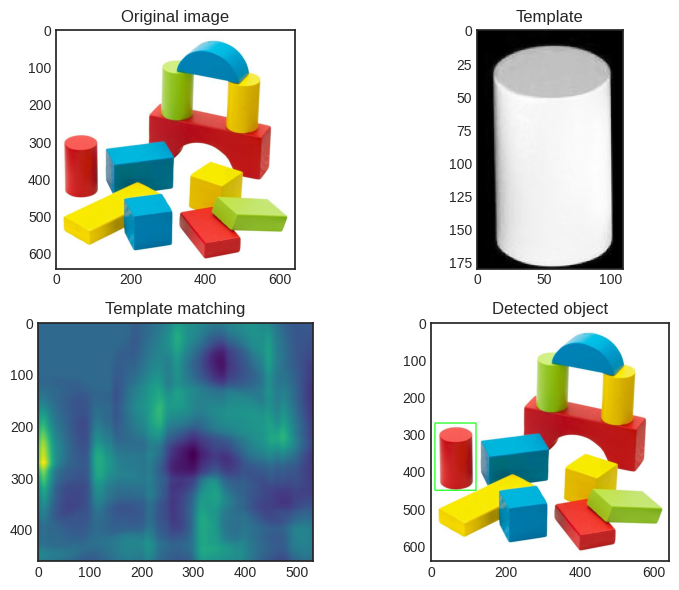

In [6]:
# Load the image
blocks_original = cv2.imread(os.path.join(images_dir, 'toy_blocks.jpg'))
blocks_original = cv2.cvtColor(blocks_original, cv2.COLOR_BGR2RGB)

# Convert to grayscale
blocks_grayscale = cv2.cvtColor(blocks_original, cv2.COLOR_BGR2GRAY)

# Create a template
min_row, max_row, min_col, max_col = 270, 450, 10, 120
template = blocks_grayscale[min_row:max_row, min_col:max_col]
# Get the width and height of the template
temp_width, temp_height = template.shape[1], template.shape[0]

# Perform template matching over image
result = cv2.matchTemplate(blocks_grayscale, template, cv2.TM_CCOEFF)

# Get the best match position
_, _, min_loc, max_loc = cv2.minMaxLoc(result)

# Draw a bounding box around the best match
top_left = max_loc
bottom_right = (top_left[0]+temp_width, top_left[1]+temp_height)
bbox = cv2.rectangle(blocks_original.copy(), top_left, bottom_right, (0, 255, 0), 2)

# Plot the images
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
ax = axes.ravel()
ax[0].imshow(blocks_original)
ax[0].set_title('Original image')
ax[1].imshow(template)
ax[1].set_title('Template')
ax[2].imshow(result, cmap='viridis')
ax[2].set_title('Template matching')
ax[3].imshow(bbox)
ax[3].set_title('Detected object')
fig.tight_layout()
plt.show()

## 1.2 HAAR Cascade Classifier

The Viola-Jones algorithm uses simple HAAR features obtained by passing rectangular kernels over the image and calculating the difference between the sum of pixels within the black and white regions of the kernel.

Viola-Jones uses AdaBoost to choose the best HAAR features and finally, a ‘cascade’ evaluates the sequence of simple classifiers for each sub-image. If any returns negative (no face) the sub-image is discarded and not evaluated again. Thus focusing on promising regions.


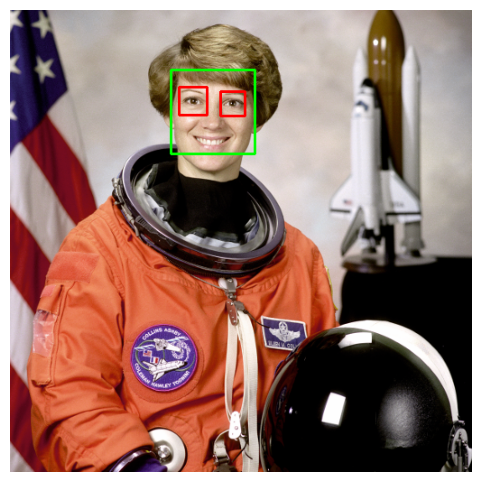

In [7]:
# Load the image
caller = getattr(data, 'astronaut')
image = caller()

# Convert to grayscale
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Create the haar cascades
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml" )
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_eye.xml")

# Detect faces and eyes
faces = face_cascade.detectMultiScale(image_gray)
eyes = eye_cascade.detectMultiScale(image_gray)

# Drawing bounding boxes for faces and eyes
for (face_x, face_y, face_w, face_h) in faces:
    image = cv2.rectangle(image, (face_x, face_y), (face_x + face_w, face_y + face_h), (0, 255, 0), 2)

for (eye_x, eye_y, eye_w, eye_h) in eyes:
    image = cv2.rectangle(image, (eye_x, eye_y), (eye_x+eye_w, eye_y+eye_h), (255, 0, 0), 2)

plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')
plt.show()

## 1.3 Exercise: Real-time face detection

We can use the CV2 video capture to perform real-time face and eye detection using HAAR Cascades.

<div class="alert alert-success" style="color:black"><b>Note:</b> Obviously, this will only work if cv2 can access a camera on your device!
</div>

In [19]:
# Enable camera
video_cap = cv2.VideoCapture(0)
video_cap.set(3, 640)
video_cap.set(4, 420)

# Create the haar cascades
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml" )
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_eye_tree_eyeglasses.xml")

while True:
    # Capture frame-by-frame
    success, frame = video_cap.read()

    # Convert to grayscale
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces and eyes
    faces = face_cascade.detectMultiScale(frame_gray, 1.3, 5)  # 1.3 = scale factor, 5 = minimum neighbour
    eyes = eye_cascade.detectMultiScale(frame_gray)
    
    # Drawing bounding boxes for faces and eyes
    for (face_x, face_y, face_w, face_h) in faces:
        cv2.rectangle(frame, (face_x, face_y), (face_x + face_w, face_y + face_h), (0, 255, 0), 2)

    for (eye_x, eye_y, eye_w, eye_h) in eyes:
        cv2.rectangle(frame, (eye_x, eye_y), (eye_x+eye_w, eye_y+eye_h), (255, 0, 0), 2)

    # Display the image
    cv2.imshow('Face and Eye Detection', frame)

    # Press 'q' to exit
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
video_cap.release()
cv2.destroyWindow('Face and Eye Detection')

[ WARN:0@1291.090] global cap_v4l.cpp:913 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ERROR:0@1291.091] global obsensor_uvc_stream_channel.cpp:158 getStreamChannelGroup Camera index out of range


error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


<div class="alert alert-success" style="color:black"><h3>Before you submit this notebook to NBGrader for marking:</h3> 

1. Make sure have completed all exercises marked by <span style="color:blue">**blue cells**</span>.
2. For automatically marked exercises ensure you have completed any cells with `# YOUR CODE HERE`. Then click 'Validate' button above, or ensure all cells run without producing an error.
3. For manually marked exercises ensure you have completed any cells with `"YOUR ANSWER HERE"`.
4. Ensure all cells are run with their output visible.
5. Fill in your student ID (**only**) below.
6. You should now **save and download** your work.

</div>

**Student ID:** 15006280